In [55]:
import pandas as pd
import numpy as np
import copy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import scipy as sc
import plotly.graph_objects as go
# import sqlite3
# from pypfopt.expected_returns import mean_historical_return
# from pypfopt.risk_models import CovarianceShrinkage
# from pypfopt.efficient_frontier import EfficientFrontier
# import pypfopt.plotting as plotting
import seaborn as sns



In [79]:
end_date = datetime.today()
start_date = end_date - timedelta(days=3000)
tickers = ['SPY','META', 'AAPL','LLY', 'GIS', 'XOM']
weights = [20,10,5,25,25,15]

In [80]:
# Import data
def getData(tickers:list, start_date:datetime, end_date:datetime):
    
    df = yf.download(tickers,
                    start=start_date,
                    end=end_date
                    )
    df = df['Adj Close']
    
    # mu = mean_historical_return(df)
    # S = CovarianceShrinkage(df).ledoit_wolf()
    # returns = df.pct_change()
    # meanReturns = returns.mean()
    # covMatrix = returns.cov()
    return df

df = getData(tickers, start_date, end_date)

# Calculate daily and annual returns of the stocks
returns_daily = df.pct_change()
returns_annual = returns_daily.mean() * 252

# Get daily and covariance of returns of the stocks
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

# Actual portfolio return, volatility and sharpe
def return_performance(weights, returns_annual):
    weights /= np.sum(weights)
    return_perf = np.dot(weights, returns_annual)
    return return_perf

def volatility_performance(weights, cov_annual):
    weights /= np.sum(weights)
    volatility_perf = np.sqrt(np.dot(np.array(weights).T, np.dot(cov_annual, weights)))
    return volatility_perf


actual_volatility = volatility_performance(weights, cov_annual)
actual_return = return_performance(weights, returns_annual)    
actual_sharpe = actual_return / actual_volatility

df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GIS,LLY,META,SPY,XOM
Date,,,,,,
2014-12-29,25.594793,41.094158,58.701931,80.019997,180.305725,63.885002
2014-12-30,25.282465,41.124413,58.316742,79.220001,179.338211,63.850666
2014-12-31,24.801622,40.352623,57.772408,78.019997,177.558640,63.459415
2015-01-02,24.565695,40.186165,58.668457,78.449997,177.463608,63.720253
2015-01-05,23.873640,39.459766,58.090633,77.190002,174.258667,61.976772


In [89]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# set the number of combinations for imaginary portfolios
num_assets = len(tickers)
num_portfolios = 60000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    # generate random weights and normalize.
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility

    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickers):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)


# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility','Sharpe Ratio'] + [stock+' weight' for stock in tickers]

# reorder dataframe columns
df = df[column_order]


# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
# find max Volatility & max Returns values in the dataframe (df) for x_lim and y_lim
max_volatility = df['Volatility'].max()
max_return = df['Returns'].max()
min_return = df['Returns'].min()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# Plot tangent, best ratio Return(mean)/Volatility(std dev)
tangent = df.loc[(df['Returns']/df['Volatility']).idxmax()]
x_tangent = [0,tangent['Volatility'],1]
y_tangent = [0,tangent['Returns'],tangent['Returns']/tangent['Volatility']]

# Actual portfolio Return and Volatility
x_actual = [actual_volatility]
y_actual = [actual_return]


In [90]:
# Find optimal return portfolio for actual Volatility and Return

closest_volatility = df.iloc[(df['Volatility']-(actual_volatility)).abs().argsort()[:10]]
max_return_for_volatility = closest_volatility[closest_volatility['Returns']==closest_volatility['Returns'].max()]

closest_return = df.iloc[(df['Returns']-actual_return).abs().argsort()[:10]]
min_volatility_for_return = closest_return[closest_return['Volatility']==closest_return['Volatility'].min()]

min_volatility_for_return
max_return_for_volatility

print(f'''Max Return for actual volatility : {max_return_for_volatility['Volatility'].values[0] :.4f}
        {max_return_for_volatility.iloc[:,-len(tickers):].to_dict()}
        ''')
print(f'''Min Volability for actual Return : {min_volatility_for_return['Returns'].values[0] :.4f}
        {min_volatility_for_return.iloc[:,-len(tickers):].to_dict()}
        ''')

Max Return for actual volatility : 0.2087
        {'SPY weight': {29003: 0.12964961122924465}, 'META weight': {29003: 0.15438260194370423}, 'AAPL weight': {29003: 0.5426119928017239}, 'LLY weight': {29003: 0.15723808734419373}, 'GIS weight': {29003: 0.0026169172420495543}, 'XOM weight': {29003: 0.013500789439083914}}
        
Min Volability for actual Return : 0.1645
        {'SPY weight': {4860: 0.15085768920626288}, 'META weight': {4860: 0.40016929865740014}, 'AAPL weight': {4860: 0.18265454131603134}, 'LLY weight': {4860: 0.11648976448486617}, 'GIS weight': {4860: 0.13755325049609904}, 'XOM weight': {4860: 0.012275455839340343}}
        


c:\Python311\Lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


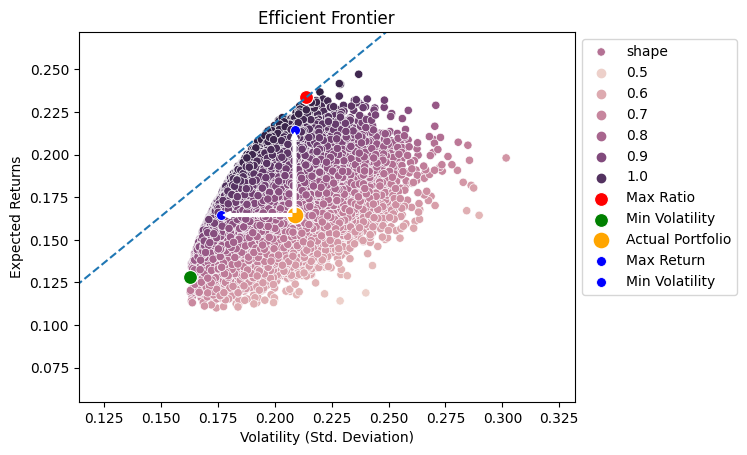

In [93]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = sns.scatterplot(data=df, x='Volatility', y='Returns', hue='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', label="shape")
sns.scatterplot(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='o', s=100, label='Max Ratio')
sns.scatterplot(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='green', marker='o', s=100, label='Min Volatility')
sns.scatterplot(x=x_actual, y=y_actual, c='orange', marker='o', s=150, label='Actual Portfolio')
sns.lineplot(x=x_tangent, y=y_tangent , linestyle='--')

sns.scatterplot(x=max_return_for_volatility['Volatility'], y=max_return_for_volatility['Returns'], c='blue', marker='o', s=50, label='Max Return')
sns.scatterplot(x=min_volatility_for_return['Volatility'], y=min_volatility_for_return['Returns'], c='blue', marker='o', s=50, label='Min Volatility')


plt.annotate("", 
            xy=(max_return_for_volatility['Volatility'], max_return_for_volatility['Returns']),
            xytext=(x_actual[0], y_actual[0]),
            arrowprops=dict(arrowstyle="simple", color="white")
            )
plt.annotate("", 
            xy=(min_volatility_for_return['Volatility'],min_volatility_for_return['Returns']),
            xytext=(x_actual[0], y_actual[0]),
            arrowprops=dict(arrowstyle="simple", color="white")
            )


# Set the axis limits
plt.xlim(min_volatility * 0.7, max_volatility * 1.1)  # add some padding to the left and right
plt.ylim(min_return * 0.5, max_return * 1.1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [84]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                 56465
Returns       0.128248
Volatility    0.162661
Sharpe Ratio  0.788441
SPY weight    0.016535
META weight   0.329913
AAPL weight   0.108561
LLY weight    0.025108
GIS weight    0.479622
XOM weight    0.040261
                  6300
Returns       0.233491
Volatility    0.213797
Sharpe Ratio  1.092116
SPY weight    0.342385
META weight   0.093625
AAPL weight   0.503721
LLY weight    0.040398
GIS weight    0.008123
XOM weight    0.011748


In [85]:
df.tail()

,Returns,Volatility,Sharpe Ratio,SPY weight,META weight,AAPL weight,LLY weight,GIS weight,XOM weight
59995,0.165737,0.194889,0.850417,0.062577,0.159020,0.209031,0.265739,0.121653,0.181979
59996,0.173892,0.196935,0.882990,0.175831,0.095961,0.183797,0.186191,0.125853,0.232367
59997,0.187639,0.204475,0.917662,0.177939,0.180203,0.227912,0.285769,0.047557,0.080621
59998,0.175895,0.192624,0.913156,0.170283,0.259907,0.175862,0.243224,0.065767,0.084957
59999,0.162164,0.187247,0.866042,0.201434,0.189721,0.097874,0.137429,0.151669,0.221874


NameError: name 'x_tg' is not defined

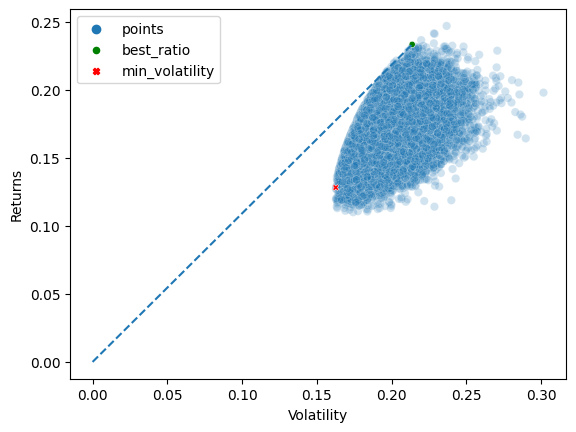

In [86]:
df['tags'] = 'points'

# min_volatility = df[df['Volatility']==df['Volatility'].min()].iloc[:,-len(tickers):].to_dict()
min_vol_index = (df['Volatility']==df['Volatility'].min())
df.loc[min_vol_index,'tags'] = 'min_volatility'
df.loc[min_vol_index]

max_ratio_index = (df['Returns']/df['Volatility']).idxmax()
df.loc[max_ratio_index, 'tags'] = 'best_ratio'
df.loc[max_ratio_index]

tangent = df.loc[(df['Returns']/df['Volatility']).idxmax()]


x_tangent = [0,tangent['Volatility']]
y_tangent = [0,tangent['Returns']]
# plot the efficient frontier with a scatter plot

ax = sns.scatterplot(data=df[df.tags=='points'], x='Volatility', y='Returns', hue='tags', alpha=0.2)

sns.scatterplot(data=df[df.tags!='points'], x='Volatility', y='Returns' , hue='tags', alpha=1, palette=["green","red"], size='tags',size_order=['min_volatility','best_ratio' ], sizes=(20,20), style = 'tags')
sns.lineplot(x=x_tangent, y=y_tangent , linestyle='--')


# Set the axis limits
plt.xlim(0.15, max(x_tg) * 1.1)  # add some padding to the left and right
plt.ylim(0.10, max(y_tg) * 1.1)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
